In [1]:
%load_ext rpy2.ipython

## This is rstan code and results for Autism, 2014 for both denovos (LOF + Mis3) and case control (LoF)

### rstan code

In [ ]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]

yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]
NN = length(y.case.lof)



casecontrol <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=1> Ndn;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

    int<lower=0> yCaseMis3[NN];
    int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> hyperBetaMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;


}

model {

real ps[K];

//lof
hyperGammaMeanLoFcc ~ normal(4, 1); //normal(14, 4);
hyperBetaLoFcc ~ normal(1, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
//denovo lof
hyperGammaMeanLoFdn ~ normal(14, 4);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

///mis3
//hyperGammaMeanMis3cc ~ normal(10, 3);
//hyperBetaMis3cc ~ normal(1, 0.01);
//gammaMis3cc ~ gamma(hyperGammaMeanLoFcc*hyperBetaMis3cc, hyperBetaMis3cc);
//denovo mis3
hyperGammaMeanMis3dn ~ normal(4, 1); //normal(14, 4);
hyperBetaMis3dn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);


for (ii in 1:NN){
ps[1] <- log1m(pi0) + binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0) 
 + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]) 
 + poisson_log(yMis3dn[ii], 2*Ndn*mutMis3[ii]);
// + binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0) 
ps[2] <- log(pi0) + binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol)) + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]*gammaLoFdn) 
  + poisson_log(yMis3dn[ii], 2*Ndn*mutMis3[ii]*gammaMis3dn); 
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol))
increment_log_prob(log_sum_exp(ps));
}

}
"
yLoF <- counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
yMis3 <- counts[, 4]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]
mutLoF <- data$mut.rate*mu.frac[1]
mutMis3 <- data$mut.rate*mu.frac[2]

mixdata3 <- list(K = 2, 
                 yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                 yLoFdn = yLoF, mutLoF = mutLoF,
                 
                 NN = length(y.case.lof),
                 Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                 Ndn = N$dn,
                 
                 yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                 yMis3dn = yMis3, mutMis3 = mutMis3,
                 thetaH0 = N$ca/(N$ca + N$cn))


testFit <- stan(model_code = casecontrol, data = mixdata3, iter = 1000, chains = 1, control = list(adapt_delta = 0.9))
#,                init = list(list(hyperGammaMeanLoF = 20, hyperBetaLoF = 1)))
#,                 control = list(adapt_delta = 0.89), algorithm = "HMC")
#, pars = c('hyperbetaLoF', 'hyperalphaMeanLoF'),
#                 algorithm = "HMC"
#, control = list(adapt_delta = 0.999))#,                 init = list(hyperbetaLoF = 1, hyperalphaMeanLoF = 24))
vSeed <- 1234
fit <- stan(fit = testFit, data = mixdata3, iter = 50000, chains = 3, thin  = 10, cores = 3, 
               seed = vSeed,
            pars = c('pi0',
              'hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn',
                     'hyperBetaLoFdn', 'hyperBetaMis3dn',
                     'hyperGammaMeanLoFcc'), 
            control = list(adapt_delta = 0.95),
            init = list(list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                                  hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                                  hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1),
                        list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                                 hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                                 hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1),
            list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                 hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                 hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1)))

fit
plot(fit)

s <- stan2coda(fit)
summary(s)
allPar <- c('pi0', 'hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn', 'hyperBetaLoFdn', 'hyperBetaMis3dn',
            'hyperGammaMeanLoFcc')
ii = 3
plot(s[, allPar[ii]], main = paste(allPar[ii], round(sapply(s[, allPar[ii]], mean), 4), sep = " "), cex = 0.5)

#save.image("~/Documents/SaveDataFromServer/rstanAllGeneAutismDataresult_data2014.RData")


In [3]:
%%R
load("/usr/data/Documents/SaveDataFromServer/rstanAllGeneAutismDataresult_data2014.RData")

by .GlobalEnv when processing object ‘fitMissensescz’


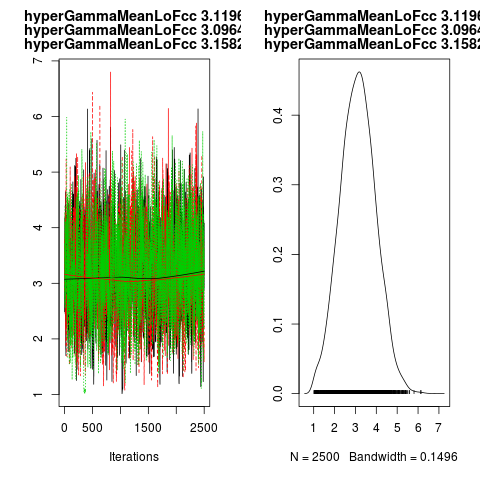

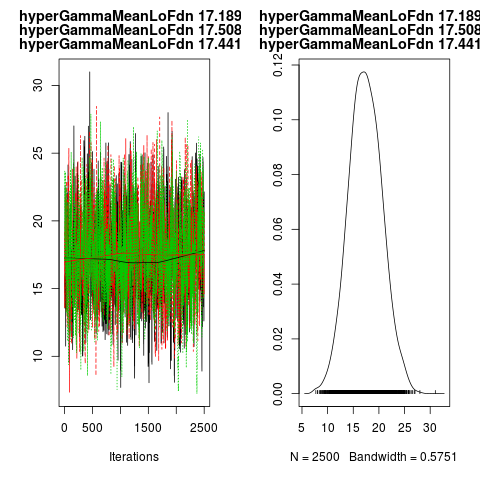

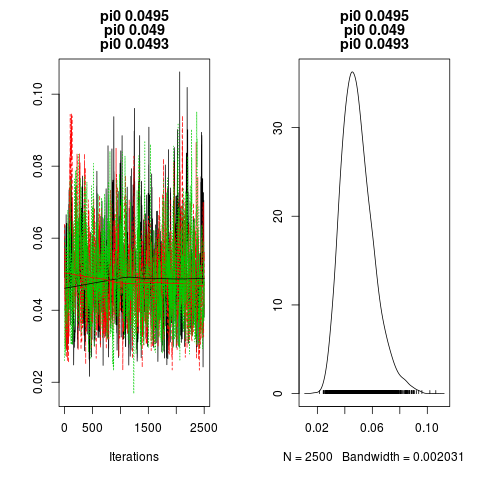

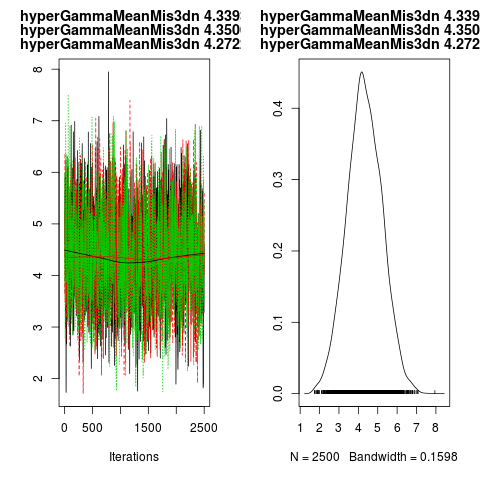

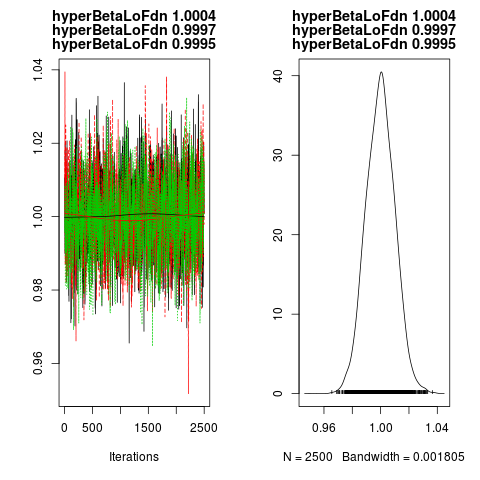

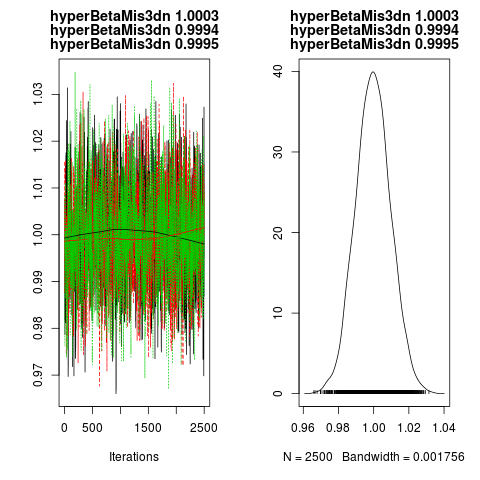

In [6]:
%%R 
library("rjags")

for (ii in 1:length(allPar))
      
plot(s[, allPar[ii]], main = paste(allPar[ii], round(sapply(s[, allPar[ii]], mean), 4), sep = " "), cex = 0.5)